In [9]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import numpy as np
import editdistance

# --- Vocabulary setup ---
VOCAB = "abcdefghijklmnopqrstuvwxyz0123456789 .,;'-"
VOCAB_DICT = {c: i+1 for i, c in enumerate(VOCAB)}  # 0 reserved for CTC blank
VOCAB_DICT["<blank>"] = 0
INV_VOCAB_DICT = {v: k for k, v in VOCAB_DICT.items()}

def text_to_int_sequence(text):
    return [VOCAB_DICT.get(c, 0) for c in text.lower()]

def int_sequence_to_text(seq):
    return "".join(INV_VOCAB_DICT.get(i, '') for i in seq)

# --- 1. Aspect ratio preserving resize + padding ---
class ResizePad:
    def __init__(self, height=32, max_width=512):
        self.height = height
        self.max_width = max_width

    def __call__(self, img):
        w, h = img.size
        new_w = int(w * (self.height / h))
        img = img.resize((new_w, self.height), Image.BILINEAR)
        if new_w < self.max_width:
            new_img = Image.new('L', (self.max_width, self.height), color=0)
            new_img.paste(img, (0, 0))
            return new_img
        else:
            return img.resize((self.max_width, self.height), Image.BILINEAR)

# --- 2. Dataset with augmentation ---
class RIMESDataset(Dataset):
    def __init__(self, filenames, images_dir, transcriptions_dir, max_width=512, augment=False):
        self.filenames = filenames
        self.images_dir = images_dir
        self.transcriptions_dir = transcriptions_dir
        self.max_width = max_width
        self.augment = augment

        self.resize_pad = ResizePad(height=32, max_width=max_width)
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize((0.5,), (0.5,))

        # Augmentations
        self.augmentations = transforms.Compose([
            transforms.RandomRotation(degrees=3, fill=0),
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img_path = os.path.join(self.images_dir, filename + ".jpg")
        txt_path = os.path.join(self.transcriptions_dir, filename + ".txt")

        image = Image.open(img_path).convert("L")  # grayscale
        image = self.resize_pad(image)

        if self.augment:
            image = self.augmentations(image)

        image = self.to_tensor(image)
        image = self.normalize(image)

        with open(txt_path, "r", encoding="utf-8") as f:
            transcription = f.read().strip()

        label = torch.tensor(text_to_int_sequence(transcription), dtype=torch.long)
        return image, label

# --- 3. Collate function ---
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, 0)
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels = pad_sequence(labels, batch_first=True, padding_value=0)
    return images, labels, label_lengths

# --- 4. Improved CRNN model ---
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d((2,1), (2,1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d((2,1), (2,1)),
            nn.Conv2d(512, 512, 2, 1, 0), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.lstm1 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        conv = self.cnn(x)  # [batch, channels, height=1, width]
        conv = conv.squeeze(2)  # remove height dim
        conv = conv.permute(0, 2, 1)  # [batch, width, channels]

        rnn_out, _ = self.lstm1(conv)
        rnn_out, _ = self.lstm2(rnn_out)

        output = self.fc(rnn_out)
        output = output.log_softmax(2)
        return output

# --- 5. Load splits ---
def load_split_filenames(split_txt_path):
    with open(split_txt_path, "r") as f:
        filenames = [line.strip() for line in f.readlines()]
    return filenames

root_dir = "/kaggle/input/rimes-lines-dataset/RIMES-2011-Lines"
sets_dir = os.path.join(root_dir, "Sets")
images_dir = os.path.join(root_dir, "Images")
transcriptions_dir = os.path.join(root_dir, "Transcriptions")

train_files = load_split_filenames(os.path.join(sets_dir, "TrainLines.txt"))
val_files = load_split_filenames(os.path.join(sets_dir, "ValidationLines.txt"))

# --- 6. Create datasets and loaders ---
train_dataset = RIMESDataset(train_files, images_dir, transcriptions_dir, augment=True)
val_dataset = RIMESDataset(val_files, images_dir, transcriptions_dir, augment=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# --- 7. Setup model, criterion, optimizer, scheduler ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(num_classes=len(VOCAB_DICT)).to(device)

criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

# --- 8. Decoding function ---
def greedy_decode(log_probs, blank=0):
    argmaxes = torch.argmax(log_probs, dim=2)
    decoded_texts = []
    for seq in argmaxes:
        decoded = []
        prev = blank
        for idx in seq:
            idx = idx.item()
            if idx != prev and idx != blank:
                decoded.append(INV_VOCAB_DICT.get(idx, ''))
            prev = idx
        decoded_texts.append(''.join(decoded))
    return decoded_texts

# --- 9. CER calculation ---
def cer(pred, target):
    return editdistance.eval(pred, target) / max(len(target), 1)

# --- 10. Training loop ---
num_epochs = 21
grad_clip = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels, label_lengths in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # [batch, width, num_classes]

        batch_size = images.size(0)
        input_lengths = torch.full(size=(batch_size,), fill_value=outputs.size(1), dtype=torch.long).to(device)

        loss = criterion(outputs.permute(1, 0, 2), labels, input_lengths, label_lengths)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} training loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    total_cer = 0
    count = 0
    with torch.no_grad():
        for images, labels, label_lengths in val_loader:
            images = images.to(device)
            outputs = model(images)
            log_probs = outputs.cpu()
            preds = greedy_decode(log_probs)

            targets = []
            for i, length in enumerate(label_lengths):
                seq = labels[i, :length].tolist()  # Get the i-th label, up to its length
                text = ''.join(INV_VOCAB_DICT.get(i, '') for i in seq)
                targets.append(text)

            for p, t in zip(preds, targets):
                total_cer += cer(p, t)
                count += 1

    avg_cer = total_cer / count
    print(f"Epoch {epoch+1} validation CER: {avg_cer:.4f}")
    print(f"Learning rate: {scheduler.get_last_lr()[0]:.6f}")

    scheduler.step(avg_cer)

# --- 11. Save model ---
torch.save(model.state_dict(), "crnn_rimes_augmented.pth")
print("Model saved!")

100%|██████████| 637/637 [01:15<00:00,  8.48it/s]


Epoch 1 training loss: 2.4019
Epoch 1 validation CER: 0.5894
Learning rate: 0.001000


100%|██████████| 637/637 [01:14<00:00,  8.54it/s]


Epoch 2 training loss: 1.1641
Epoch 2 validation CER: 0.3416
Learning rate: 0.001000


100%|██████████| 637/637 [01:14<00:00,  8.50it/s]


Epoch 3 training loss: 0.6961
Epoch 3 validation CER: 0.2814
Learning rate: 0.001000


100%|██████████| 637/637 [01:14<00:00,  8.61it/s]


Epoch 4 training loss: 0.5253
Epoch 4 validation CER: 0.2663
Learning rate: 0.001000


100%|██████████| 637/637 [01:13<00:00,  8.61it/s]


Epoch 5 training loss: 0.4398
Epoch 5 validation CER: 0.2470
Learning rate: 0.001000


100%|██████████| 637/637 [01:15<00:00,  8.44it/s]


Epoch 6 training loss: 0.3596
Epoch 6 validation CER: 0.2334
Learning rate: 0.001000


100%|██████████| 637/637 [01:14<00:00,  8.50it/s]


Epoch 7 training loss: 0.3067
Epoch 7 validation CER: 0.2244
Learning rate: 0.001000


100%|██████████| 637/637 [01:15<00:00,  8.43it/s]


Epoch 8 training loss: 0.2664
Epoch 8 validation CER: 0.2324
Learning rate: 0.001000


100%|██████████| 637/637 [01:16<00:00,  8.37it/s]


Epoch 9 training loss: 0.2336
Epoch 9 validation CER: 0.2182
Learning rate: 0.001000


100%|██████████| 637/637 [01:13<00:00,  8.62it/s]


Epoch 10 training loss: 0.2038
Epoch 10 validation CER: 0.2121
Learning rate: 0.001000


100%|██████████| 637/637 [01:14<00:00,  8.52it/s]


Epoch 11 training loss: 0.1788
Epoch 11 validation CER: 0.2131
Learning rate: 0.001000


100%|██████████| 637/637 [01:14<00:00,  8.53it/s]


Epoch 12 training loss: 0.1530
Epoch 12 validation CER: 0.2110
Learning rate: 0.001000


100%|██████████| 637/637 [01:14<00:00,  8.53it/s]


Epoch 13 training loss: 0.1282
Epoch 13 validation CER: 0.2130
Learning rate: 0.001000


100%|██████████| 637/637 [01:15<00:00,  8.48it/s]


Epoch 14 training loss: 0.1143
Epoch 14 validation CER: 0.2169
Learning rate: 0.001000


100%|██████████| 637/637 [01:15<00:00,  8.49it/s]


Epoch 15 training loss: 0.0994
Epoch 15 validation CER: 0.2113
Learning rate: 0.001000


100%|██████████| 637/637 [01:15<00:00,  8.49it/s]


Epoch 16 training loss: 0.0495
Epoch 16 validation CER: 0.1997
Learning rate: 0.000500


100%|██████████| 637/637 [01:15<00:00,  8.44it/s]


Epoch 17 training loss: 0.0288
Epoch 17 validation CER: 0.2009
Learning rate: 0.000500


100%|██████████| 637/637 [01:16<00:00,  8.37it/s]


Epoch 18 training loss: 0.0228
Epoch 18 validation CER: 0.2006
Learning rate: 0.000500


100%|██████████| 637/637 [01:14<00:00,  8.51it/s]


Epoch 19 training loss: 0.0106
Epoch 19 validation CER: 0.1994
Learning rate: 0.000500


100%|██████████| 637/637 [01:15<00:00,  8.46it/s]


Epoch 20 training loss: 0.0065
Epoch 20 validation CER: 0.2019
Learning rate: 0.000500


100%|██████████| 637/637 [01:14<00:00,  8.53it/s]


Epoch 21 training loss: 0.0016
Epoch 21 validation CER: 0.2020
Learning rate: 0.000500
Model saved!


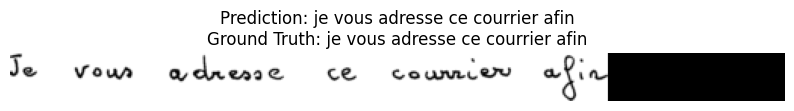

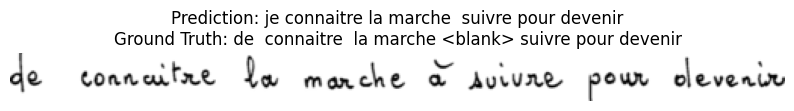

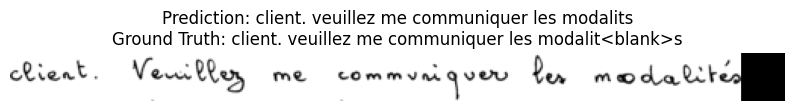

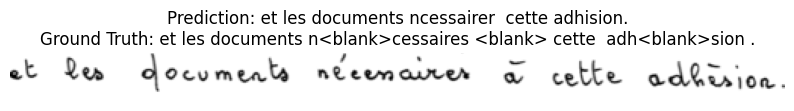

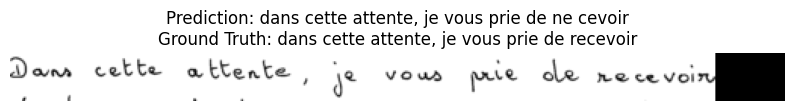

In [12]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, labels, label_lengths in val_loader:
        images = images.to(device)
        outputs = model(images)
        log_probs = outputs.cpu()

        preds = greedy_decode(log_probs)

        # Prepare ground truth texts
        targets = []
        for i, length in enumerate(label_lengths):
            seq = labels[i, :length].tolist()  # Correct slicing here
            text = ''.join(INV_VOCAB_DICT.get(ch, '') for ch in seq)
            targets.append(text)

        # Show up to 5 samples
        for i in range(min(5, images.size(0))):
            img = images[i].cpu().squeeze(0)  # [H, W]
            plt.figure(figsize=(10, 2))
            plt.imshow(img, cmap='gray')
            plt.title(f"Prediction: {preds[i]}\nGround Truth: {targets[i]}")
            plt.axis('off')
            plt.show()
        break


In [13]:
from IPython.display import FileLink
FileLink('crnn_rimes_augmented.pth')


/kaggle/working/crnn_rimes_augmented.pth

In [14]:
image_dir = '/kaggle/input/01dataset/datacomplete2'


In [15]:
import pandas as pd

annotation_path = '/kaggle/input/nowthisisthedata/datacomplete2.xlsx'
df = pd.read_excel(annotation_path)  # Use read_csv if it's a CSV

# Select and rename only the needed columns
df = df.rename(columns={'image': 'image', 'texte': 'texte'})

# Or, if your columns are not already named 'image' and 'texte', check their names:
print(df.columns)

# Then select only the relevant columns:
df = df[['image', 'texte']]
print(df.head())


Index(['image', 'texte', 'Unnamed: 2', 'Unnamed: 3'], dtype='object')
   image           texte
0  1.jpg      20/06/2023
1  2.jpg              99
2  4.jpg              70
3  5.jpg             791
4  6.jpg  bandelette TOT


In [16]:
import pandas as pd

annotation_path = '/kaggle/input/nowthisisthedata/datacomplete2.xlsx'
df = pd.read_excel(annotation_path)  # Use read_csv if it's a CSV

# Select only the 'image' and 'texte' columns
df = df[['image', 'texte']]

print(df.head())


   image           texte
0  1.jpg      20/06/2023
1  2.jpg              99
2  4.jpg              70
3  5.jpg             791
4  6.jpg  bandelette TOT


In [17]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import os

VOCAB = "abcdefghijklmnopqrstuvwxyz0123456789 .,;'-/"
VOCAB_DICT = {c: i + 1 for i, c in enumerate(VOCAB)}  # 0 reserved for CTC blank
VOCAB_DICT["<blank>"] = 0

def text_to_int_sequence(text):
    text = str(text).lower()
    return [VOCAB_DICT.get(c, 0) for c in text]

class HandwritingDataset(Dataset):
    def __init__(self, image_dir, dataframe, augment=True):
        self.image_dir = image_dir
        self.data = dataframe.reset_index(drop=True)
        self.augment = augment

        self.max_width = 512
        self.height = 32

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize((0.5,), (0.5,))

        self.augmentations = transforms.Compose([
            transforms.RandomRotation(degrees=3, fill=0),
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
        ])

    def resize_and_pad(self, img):
        w, h = img.size
        new_w = int(w * (self.height / h))
        img = img.resize((new_w, self.height), Image.BILINEAR)
        if new_w < self.max_width:
            new_img = Image.new('L', (self.max_width, self.height), color=0)
            new_img.paste(img, (0, 0))
            return new_img
        else:
            return img.resize((self.max_width, self.height), Image.BILINEAR)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image'])
        transcription = row['texte']

        image = Image.open(img_path).convert('L')
        image = self.resize_and_pad(image)

        if self.augment:
            image = self.augmentations(image)

        image = self.to_tensor(image)
        image = self.normalize(image)

        label = torch.tensor(text_to_int_sequence(transcription), dtype=torch.long)
        return image, label


In [18]:
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, 0)
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels = torch.cat(labels)
    return images, labels, label_lengths


In [19]:
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),

            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),

            nn.Conv2d(512, 512, 2, 1, 0), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.lstm1 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        conv = self.cnn(x)
        conv = conv.squeeze(2)
        conv = conv.permute(0, 2, 1)
        rnn_out, _ = self.lstm1(conv)
        rnn_out, _ = self.lstm2(rnn_out)
        output = self.fc(rnn_out)
        output = output.log_softmax(2)
        return output


In [20]:
from torch.utils.data import random_split

# Assuming df is your dataframe with 'image' and 'texte' columns
dataset = HandwritingDataset(image_dir, df, augment=True)

total_len = len(dataset)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len

train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))


In [21]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [22]:
from tqdm import tqdm
import torch.optim as optim

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels, label_lengths in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        batch_size = images.size(0)
        input_lengths = torch.full(size=(batch_size,), fill_value=outputs.size(1), dtype=torch.long).to(device)
        loss = criterion(outputs.permute(1, 0, 2), labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, labels, label_lengths in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            batch_size = images.size(0)
            input_lengths = torch.full(size=(batch_size,), fill_value=outputs.size(1), dtype=torch.long).to(device)
            loss = criterion(outputs.permute(1, 0, 2), labels, input_lengths, label_lengths)
            total_loss += loss.item()
    return total_loss / len(dataloader)


In [23]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(VOCAB_DICT)

model = CRNN(num_classes=num_classes).to(device)

pretrained_path = '/kaggle/input/themodelpre/crnn_rimes_augmented (1).pth'  # Adjust if different

# Load pretrained weights except final fc layer to avoid size mismatch
state_dict = torch.load(pretrained_path, map_location=device)
if 'fc.weight' in state_dict:
    del state_dict['fc.weight']
if 'fc.bias' in state_dict:
    del state_dict['fc.bias']

model.load_state_dict(state_dict, strict=False)
print("Pretrained model loaded (excluding final layer).")


/tmp/ipykernel_31/4229173357.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_path, map_location=device)


Pretrained model loaded (excluding final layer).


In [24]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [34]:
from tqdm import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels, label_lengths in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        batch_size = images.size(0)
        input_lengths = torch.full(size=(batch_size,), fill_value=outputs.size(1), dtype=torch.long).to(device)
        loss = criterion(outputs.permute(1, 0, 2), labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels, label_lengths in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            batch_size = images.size(0)
            input_lengths = torch.full(size=(batch_size,), fill_value=outputs.size(1), dtype=torch.long).to(device)
            loss = criterion(outputs.permute(1, 0, 2), labels, input_lengths, label_lengths)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")


100%|██████████| 252/252 [00:24<00:00, 10.29it/s]


Epoch 1/5 - Train Loss: 0.6337 - Val Loss: 0.9613


100%|██████████| 252/252 [00:24<00:00, 10.41it/s]


Epoch 2/5 - Train Loss: 0.6079 - Val Loss: 0.9742


100%|██████████| 252/252 [00:24<00:00, 10.29it/s]


Epoch 3/5 - Train Loss: 0.5977 - Val Loss: 0.9757


100%|██████████| 252/252 [00:23<00:00, 10.51it/s]


Epoch 4/5 - Train Loss: 0.5980 - Val Loss: 0.9298


100%|██████████| 252/252 [00:23<00:00, 10.53it/s]


Epoch 5/5 - Train Loss: 0.5724 - Val Loss: 0.9459


In [35]:
INV_VOCAB_DICT = {v: k for k, v in VOCAB_DICT.items()}

def greedy_decode(log_probs, blank=0):
    argmaxes = torch.argmax(log_probs, dim=2)
    decoded_texts = []
    for seq in argmaxes:
        decoded = []
        prev = blank
        for idx in seq:
            idx = idx.item()
            if idx != prev and idx != blank:
                decoded.append(INV_VOCAB_DICT.get(idx, ''))
            prev = idx
        decoded_texts.append(''.join(decoded))
    return decoded_texts


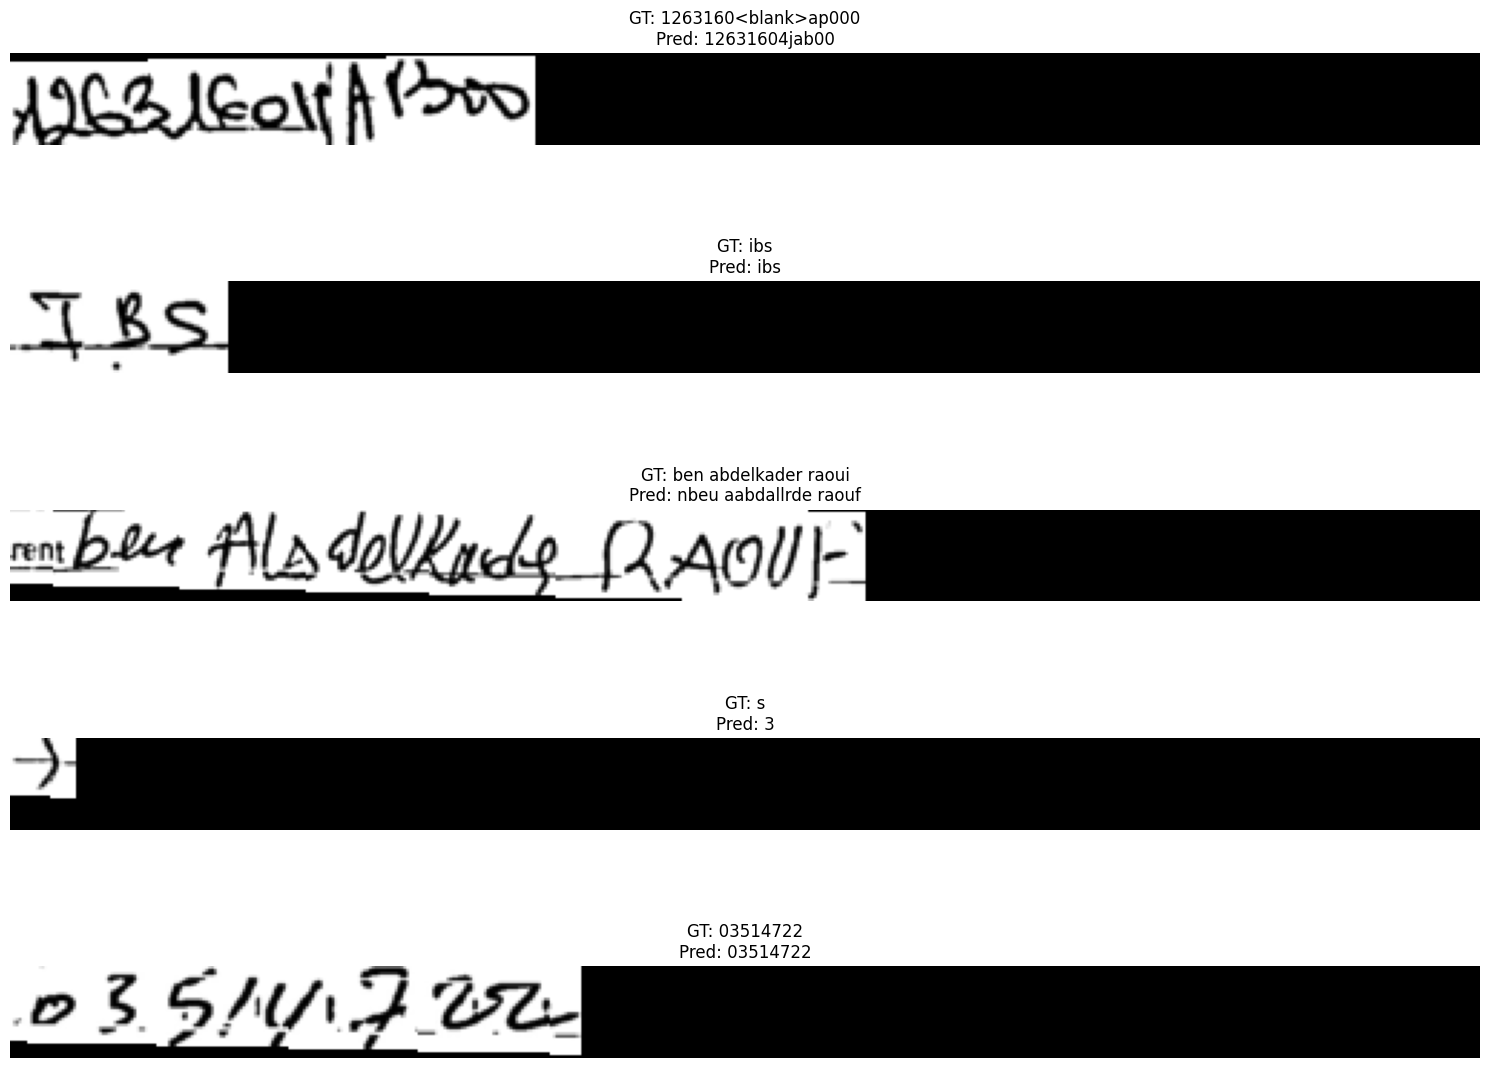

In [36]:
import matplotlib.pyplot as plt

model.eval()
plt.figure(figsize=(15, 12))
with torch.no_grad():
    for i in range(5):  # Show 5 examples
        img, label = test_set[i]
        img_input = img.unsqueeze(0).to(device)
        output = model(img_input)
        pred_text = greedy_decode(output.cpu())[0]
        true_text = ''.join([INV_VOCAB_DICT.get(c.item(), '') for c in label])

        plt.subplot(5, 1, i+1)
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.title(f"GT: {true_text}\nPred: {pred_text}")
        plt.axis('off')
plt.tight_layout()
plt.show()


In [37]:
torch.save(model.state_dict(), 'crnn_finetuned2.pth')
print("Fine-tuned model saved as crnn_finetuned.pth")


Fine-tuned model saved as crnn_finetuned.pth
